In [41]:
# Download Python Binance Library (uncomment next 2 liens if library not already installed)

import sys
!{sys.executable} -m pip install python-binance

import binance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,accuracy_score


In [23]:
# Binance API key and secret key
binance_api='g4hg1wOj6QP1lq0SavNegKi2zlRsjPEWJbGcKo7SABQCtEENmadsRdW4ZHR676Yv'
binance_secret='0W1uLsUY7H5VqfFRydvNSB2S7I2KlGFULRDKHGklhlfmsQhOJTKzCeXO5MOQ8ldp'

In [24]:
# Initialize Binance API
client = binance.Client(binance_api, binance_secret)

In [25]:
# Pull k-line historical data for ADA
START = '1609459200' # Start string - Jan 1 2020 (Beginning of the year until now of historical data)
k_line_type = binance.enums.HistoricalKlinesType.SPOT
ADA_SYMBOL = 'ADAUSDT'
KLINE_INTERVAL = '12h'
hist_data = client.get_historical_klines(symbol=ADA_SYMBOL,interval=KLINE_INTERVAL,start_str=START,klines_type=k_line_type)

In [ ]:
hist_data

## Example Format for hist_data
  [<br>
    1499040000000,      # Open time 
    <br>
    0.01634790,       # Open
    <br>
    0.80000000,       # High 
    <br>
    0.01575800,       # Low 
    <br>
    0.01577100,       # Close 
    <br>
    148976.11427815,  # Volume 
    <br>
    1499644799999,      # Close time
    <br>
    2434.19055334,    # Quote asset volume
    <br>
    308,                # Number of trades 
    <br>
    1756.87402397,    # Taker buy base asset volume 
    <br>
    28.46694368,      # Taker buy quote asset volume
    <br>
    17928899.62484339 # Ignore 
    <br>
  ]
  
 Source: https://sammchardy.github.io/historical-data-download-binance/

In [26]:
# Initialize relevant data into DataFrame to use with model
time = []
open_list = []
high_list = []
low_list = []
close_list = []
trend = [] # 0 for open == close , 1 for open < close, -1 for close > open
next_day_trend = []
for i in range(len(hist_data)-1):
    time.append(datetime.datetime.fromtimestamp(hist_data[i][0]/1000))
    open_list.append(hist_data[i][1])
    high_list.append(hist_data[i][2])
    low_list.append(hist_data[i][3])
    close_list.append(hist_data[i][4])
    if (float(hist_data[i][4])-float(hist_data[i][1])) > 0:
        trend.append(1)
    if (float(hist_data[i][4])-float(hist_data[i][1])) < 0:
#         trend.append(-1)
        trend.append(0)
    if (float(hist_data[i][4])-float(hist_data[i][1])) == 0:
        trend.append(0)
    if (float(hist_data[i+1][4])-float(hist_data[i][4])) > 0:
        next_day_trend.append(1)
    if (float(hist_data[i+1][4])-float(hist_data[i][4])) < 0:
#         next_day_trend.append(-1)
        next_day_trend.append(0)
    if (float(hist_data[i+1][4])-float(hist_data[i][4])) == 0:
        next_day_trend.append(0)
df = pd.DataFrame(list(zip(time, open_list, high_list, low_list, close_list, trend, next_day_trend)),
               columns =['Time','Open', 'High', 'Low', 'Close', 'Single_Day_Trend', 'Two_Day_Trend'])
df.head()

,Time,Open,High,Low,Close,Single_Day_Trend,Two_Day_Trend
0,2021-01-01 00:00:00,0.18134000,0.18473000,0.17673000,0.17950000,0,0
1,2021-01-01 12:00:00,0.17943000,0.18359000,0.17000000,0.17509000,0,0
2,2021-01-02 00:00:00,0.17505000,0.17618000,0.16793000,0.17204000,0,1
3,2021-01-02 12:00:00,0.17207000,0.18457000,0.17026000,0.17742000,1,1
4,2021-01-03 00:00:00,0.17740000,0.19420000,0.17255000,0.18882000,1,1


In [27]:
# Split relevant variables into matrices and split into train and test groups
y, X = df['Two_Day_Trend'], [df['High'],df['Low'],df['Close'],df['Single_Day_Trend']]
X_train, X_test, y_train, y_test = train_test_split(np.array(X).T, y, test_size=0.33, random_state=42)

# kNN Model

In [60]:
# p = 2 is equivalent to using the euclidean distance
# weights = 'distance' means closer points are weighted more heavily than further away points
n_neighbors = 5
model1 = KNeighborsClassifier(n_neighbors=n_neighbors,weights='distance',algorithm='auto',p=2)
model1.fit(X_train,y_train)
y_hat_train = model1.predict(X_train)
y_hat_test = model1.predict(X_test)
train_accuracy = accuracy_score(y_train,y_hat_train)
test_accuracy = accuracy_score(y_test,y_hat_test)

print(f"Train Accuracy for KNeighborsClassifier:{train_accuracy}")
print(f"Test Accuracy for KNeighborsClassifier:{test_accuracy}")



Train Accuracy for KNeighborsClassifier:1.0
Test Accuracy for KNeighborsClassifier:0.5113636363636364


In [47]:
type(y_hat_train)

numpy.ndarray

Precision:  0.5113636363636364
Accuracy:  0.4358974358974359
F1 Score:  0.44155844155844154


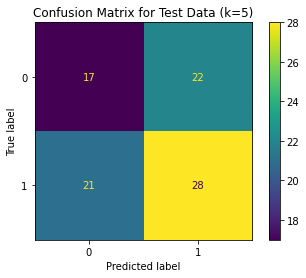

In [34]:
cm_Test1 = confusion_matrix(y_test,y_hat1)
disp = ConfusionMatrixDisplay(cm_Test1,display_labels=model1.classes_)
disp.plot()
plt.title('Confusion Matrix for Test Data (k=%i)' %(n_neighbors));
print('Accuracy: ', (cm_Test1[0][0]+cm_Test1[1][1])/(cm_Test1[0][0]+cm_Test1[0][1]+cm_Test1[1][0]+cm_Test1[1][1]))
print('Precision: ',(cm_Test1[0][0])/(cm_Test1[0][0]+cm_Test1[0][1]))
print('F1 Score: ', f1_score(y_test, y_hat1, average=None)[0])

In [58]:
cm_Test1[0][1]

22

In [59]:
(cm_Test1[0][0]+cm_Test1[0][1])

39

# Random Forest Model

In [55]:
class_weights = {'Single_Day_Trend':1,'Close':0.85,'High':0.45,'Low':0.45}
model2 = RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=20,min_samples_split=4,max_features='auto', random_state=1234)
model2.fit(X_train,y_train)
y_hat2 = model2.predict(X_test)

y_hat2_train = model2.predict(X_train)
y_hat2_test = model2.predict(X_test)
train_accuracy_rf = accuracy_score(y_train,y_hat2_train)
test_accuracy_rf = accuracy_score(y_test,y_hat2_test)

print(f"Train Accuracy for random forest:{train_accuracy_rf}")
print(f"Test Accuracy for random forest:{test_accuracy_rf}")



Train Accuracy for random forest:0.9774011299435028
Test Accuracy for random forest:0.6818181818181818


Accuracy:  0.6818181818181818
Precision:  0.5641025641025641
F1 Score:  0.7307692307692308


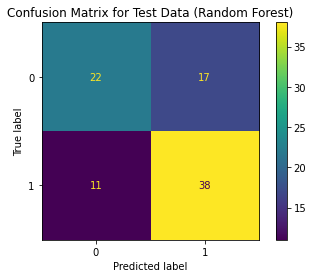

In [61]:
cm_Test2 = confusion_matrix(y_test,y_hat2)
disp = ConfusionMatrixDisplay(cm_Test2,display_labels=model2.classes_)
disp.plot()
plt.title('Confusion Matrix for Test Data (Random Forest)');
print('Accuracy: ', (cm_Test2[0][0]+cm_Test2[1][1])/(cm_Test2[0][0]+cm_Test2[0][1]+cm_Test2[1][0]+cm_Test2[1][1]))
print('Precision: ',(cm_Test2[0][0])/(cm_Test2[0][0]+cm_Test2[0][1]))
print('F1 Score: ', f1_score(y_test, y_hat2, average=None)[1])